# Simulator Testing 0

The following code defines an ellipse corresponding to the path around the globe an orbit takes

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplp

class Ellipse:
    def __init__(self, centre, height, width, angle=0):
        self.x, self.y = centre
        self.w = width
        self.h = height
        self.theta = angle
    
    def r(self):
        """
        Defines the rotation matrix used to transform coordinates to 0-centred model
        """
        a = np.cos(self.theta)
        b = np.sin(self.theta)
        return np.array([[a,-b],[b,a]])
    
    def point_at_angle(self, angle):
        """
        Given an interior angle from an ellipse's centre, finds a point on the ellipse.
        """
        #Compute location of original point
        x_or = 0.5 * self.w * np.cos(angle)
        y_or = 0.5 * self.w * np.sin(angle)

        #rotate the point to the centred version of the ellipse
        rot_point = np.dot(self.r(), [x_or, y_or]) + [self.x, self.y]
        return rot_point
    
    def multi_points(self, locations):
        """
        Given an array of interior angles, this returns an array of positions on the ellipse.
        """
        points_array = []
        for loc in locations:
            points_array.append(self.point_at_angle(self,loc))
        return np.array(points_array)
    
    def closest_point(self, x, tol=1e-6, max_iter = 100):
        """
        Given a point outside the ellipse, and finds the point on the ellipse closest to this.
        It also returns the (smallest) distance between the point and the ellipse.
        """
        #First need to project the point to the space where ellipse centred at origin
        #Also, need to initialize the constants
        x = np.asarray(x)
        x2 = np.dot(self.r().T, x - [self.x, self.y])
        d0 = np.arctan2(x2[1], x2[0])
        a = 0.5 * self.w
        b = 0.5 * self.h
        #Check if points are in the interior of the ellipse
        if (x2[0] / a)**2 + (x2[1] / b)**2 <1:
            print("Initial point in interior!")
            return np.array(0), None
        
        iterations = 0
        ds = [d0]
        xs = []
        errors = [tol]

        while errors[-1] >= tol and iterations < max_iter:
            x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
            xs.append(x1)
            dx1dt = np.array([-a *np.sin(ds[-1]), b * np.cos(ds[-1])])
            dx1dt2 = np.array([-a * np.cos(ds[-1]), -b * np.sin(ds[-1])])
            dD2dt = 2*np.dot(dx1dt,(x1 - x2))
            dD2dt2 = 2*np.dot(dx1dt2,(x1-x2)) + 2*np.dot(dx1dt,dx1dt)
            ds.append(ds[-1] - dD2dt / dD2dt2)
            errors.append(np.abs(dD2dt/dD2dt2))
            iterations +=1
        
        x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
        dist = np.linalg.norm(x1 - x2)
        return dist, xs[-1]




In [22]:
#Some quick tests
ellipse1 = Ellipse((0,0),10,20, np.deg2rad(0))
print(ellipse1.closest_point([14,14]))

(12.511067971689593, array([7.63442312, 3.22938011]))


To Be Fixed: currently only keeps track of position for (0,0) centred ellipse coords! Needs to be fixed!

In [4]:
#Here are some global variables
M_e = 5.972e24
G = 6.673e-11


In [5]:
class Satellite:
    def __init__(self, mass, dragcoeff, init_position, init_veloc):
        """
        Begin by defining relevant attributes of a satellite, initial poisition,
        and set up arrays to track movement of satellite.
        """
        self.mass = mass
        self.altitude = None
        self.althist = None
        self.dragcoeff = dragcoeff
        self.position = init_position
        self.velocity = init_veloc
        self.poshist = [init_position]
        self.velochist = [init_veloc]

    def calcAltitude(self, ell: Ellipse):
        """
        Given a satellite and an ellipse, this performs the same calculation as the ellipse
        But more from a "Sattelite" POV
        """
        altitude, ground_pos = ell.closest_point(self.position)
        return altitude, ground_pos
    
    def calcGravAcc(self, ell: Ellipse):
        """
        Given a satellite's position, and accounting for non-zero-centred ellipses, computes
        The gravitational accelleration experienced by the satellite at that position
        """
        grav_acc = -G*M_e / np.linalg.norm(np.array(self.position) - np.array([ell.x, ell.y]))**2
        theta = np.arctan2(self.position[1], self.position[0])
        return np.array([grav_acc * np.cos(theta),grav_acc * np.sin(theta)])

    def calcDrag(self, altitude):
        """
        Ideally takes a reference from the physical parameters team to estimate drag
        """
        rho_0 = 1.225
        H = 8400.0
        A = np.pi * (self.dragcoeff / 2)**2

        cur_veloc = self.velochist[-1]
        rho = rho_0 * np.exp(-(altitude) / H)
        Fd_x = 0.5 * rho * cur_veloc[0]**2 * self.dragcoeff * A
        Fd_y = 0.5 * rho * cur_veloc[1]**2 * self.dragcoeff * A
        return np.array([Fd_x, Fd_y])
    
    def FEtimeStep(self, ell: Ellipse, dt):
        """
        Takes a timestep using Forward Euler
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return 
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = drag_a + grav_a
        new_veloc = self.velochist[-1] + dt * tot_a
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        new_position = self.poshist[-1] + dt * self.velocity
        self.position = new_position
        self.poshist.append(new_position)
    
    def forecast(self, ell: Ellipse, dt=0.01, maxIter = 100000, height_tol = 10000):
        """
        Runs the forward euler timestep until our altitude reaches 0. Can adjust dt as seen fit
        To be fixed: breaks when altitude drops below 10km or so.
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        iter = 0

        if self.althist is None:
            self.althist = [self.altitude]
        
        while self.altitude > height_tol and iter < maxIter:
            self.FEtimeStep(ell, dt)
            self.althist.append(self.altitude)
        return self.poshist, self.velochist, self.althist


In [6]:
sat1 = Satellite(3000, 2.2, [7378000, 0], [0,50])
ell1 = Ellipse((0,0), 6378000*2, 6378000*2)

In [7]:
sat1.calcAltitude(ell1)

(1000000.0, array([6378000.,       0.]))

In [8]:
#print(ell1.closest_point([7378, 0]))
dt = 0.001
poshist, velochist, althist = sat1.forecast(ell1, dt = 0.001)

In [32]:
def orbitplotter(poshist, althist, ell1):
    fig, axs = plt.subplots(1,2)
    axs.flatten()[0].plot(althist[0::100], label = "Altitude")
    axs.flatten()[0].set_xlabel("Time (1/10 s)")
    axs.flatten()[0].set_ylabel("Altitude (m)")
    axs.flatten()[1].plot(poshist[:,0], poshist[:,1], label = "Position")
    ellipse = mplp.Ellipse((ell1.x,ell1.y),ell1.w, ell1.h, angle = ell1.theta, fill=False, color = 'r')
    axs.flatten()[1].add_patch(ellipse)

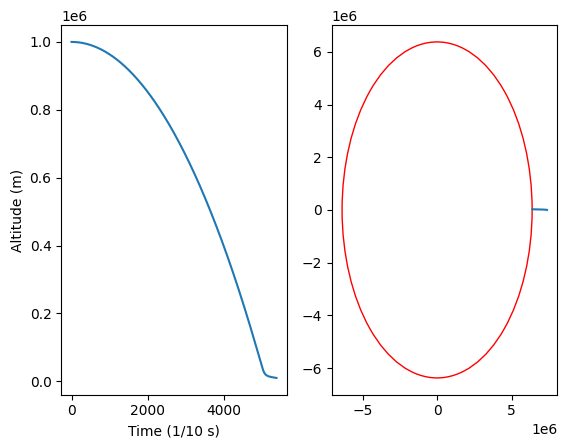

In [33]:
poshist = np.array(poshist)
orbitplotter(poshist, althist, ell1)